# Fitting the KAGRA Typical LVDT and and Geophone noise with Transfer Function

For LVDT and geophone noise, we assume their amplitude spectral densities (ASDs) follows the empirical model

\begin{equation}
    N_\mathrm{model}(f; n_a, n_b, a, b) = \left[\left(\frac{n_a}{f^a}\right)^2 + \left(\frac{n_b}{f^b}\right)^2\right]^{\frac{1}{2}}\,\frac{\mu \mathrm{m}}{\sqrt{\mathrm{Hz}}}
\end{equation}

Here're some typical values for LVDTs and Geophones

| Sensor  | $n_a$ | $n_b$ | $a$ | $b$ |
|  :----:  | :---- | :---- | :---- | :---- |
|  LVDT   |   1e-2.07   |   1e-2.3   |  0.5  |  0  |
|  Geophone | 1e-5.46   |   1e-5.23   |  3.5  |  1  |

In this tutorial, we will demonstrate the use of `kontrol.curvefit.CurveFit` for fitting a transfer function for noise amplitudes. The fitted noise models will be exported and be used in the complementary filter tutorial.
To Fit the noise with a transfer function, we use a ZPK model `kontrol.curvefit.model.SimpleZPK` as an intermediate step.
The benefit of using a ZPK model is that the bounds are specifiable, i.e. the bounds of the frequency axis,
so a global optimization scheme, i.e. `scipy.optimize.differential_evolution()`, can be used.
After obtaining a ZPK model, it's converted to the polynomial transfer function format and it's
numerator and denominator are used for a final local fit using a transfer function model
`kontrol.curvefit.model.TransferFunctionModel()` and a local minimization scheme `scipy.optimize.minimize("method"="Nelder-Mead", ...)` to obtain the final parameters of the transfer functions.
We negate any unstable zeros and poles in the final transfer functions and they
are exported to `"noise_lvdt.pkl"` and `"noise_geophone.pkl"`, which can be read with `kontrol.load_transfer_function()`.

In [1]:
# Let's define the sensor noises
import numpy as np
import matplotlib.pyplot as plt


def model(f, na, nb, a, b):
    return np.sqrt((na/f**a)**2 + (nb/f**b)**2)

# f = np.linspace(0.001, 100, 102400)
# For the sake of demostration, use logspace. It's easier
f = np.logspace(-3, 2, 10240)
n_lvdt = model(f, na=1*10**-2.07, nb=1*10**-2.3, a=0.5, b=0)
n_geophone = model(f, na=1*10**-5.46, nb=1*10**-5.23, a=3.5, b=1)
n_lvdt_pad = np.array(n_lvdt)
n_geophone_pad = np.array(n_geophone)

In [2]:
# Make the noise flat at lower and higher frequencies so it works with h-infinity synthesis.
# Pad before f_lower and after f_upper
f_lower = 0.01
f_upper = 10
n_lvdt_lower_val = n_lvdt[f>f_lower][0]
n_lvdt_upper_val = n_lvdt[f<f_upper][-1]
n_lvdt_pad[f<f_lower] = n_lvdt_lower_val
n_lvdt_pad[f>f_upper] = n_lvdt_upper_val

n_geophone_lower_val = n_geophone[f>f_lower][0]
n_geophone_upper_val = n_geophone[f<f_upper][-1]
n_geophone_pad[f<f_lower] = n_geophone_lower_val
n_geophone_pad[f>f_upper] = n_geophone_upper_val

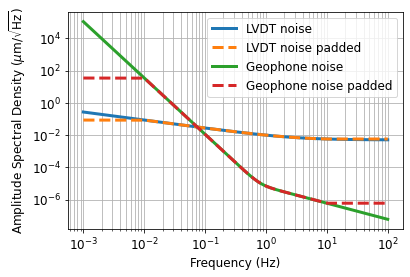

In [3]:
# Let's plot the noises
plt.figure(figsize=(6, 4))
plt.rcParams["font.size"] = 12
plt.loglog(f, n_lvdt, lw=3, label="LVDT noise")
plt.loglog(f, n_lvdt_pad, "--", lw=3, label="LVDT noise padded")
plt.loglog(f, n_geophone, lw=3, label="Geophone noise")
plt.loglog(f, n_geophone_pad, "--", lw=3, label="Geophone noise padded")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel(r"Amplitude Spectral Density ($\mu \rm{m}/\sqrt{\rm{Hz}}$)")
plt.xlabel("Frequency (Hz)")
plt.show()

Define a cost funtion

\begin{equation}
    J(\mathbf{\theta}) = \frac{1}{M}\sum_{i=1}^{M}\left[\log N_\mathrm{data}(f_i) - \log \lvert N_\mathrm{model}(f_i, \mathbf{\theta})\rvert\right]^2 
\end{equation}

In [4]:
def cost(args, model, xdata, ydata, *model_args, **kwargs):
    fit = abs(model(xdata, args))
    return np.mean((np.log10(ydata) - np.log10(fit))**2)

In [5]:
# Let's fit them with ZPK model using scipy.optimize.differential_evolution
# Let's choose a third-order model for LVDT and a fourth-order model for geophone
import scipy.optimize
import kontrol.curvefit

log_args = True  # Fit the logarithm of the arguments instead.
lvdt_order = 3
lvdt_model = kontrol.curvefit.model.SimpleZPK(nzero=lvdt_order, npole=lvdt_order, log_args=log_args)

lvdt_fit = kontrol.curvefit.CurveFit()

lvdt_fit.xdata = f
lvdt_fit.ydata = n_lvdt_pad
lvdt_fit.cost = cost
lvdt_fit.optimizer = scipy.optimize.differential_evolution
lvdt_bounds = [(min(f), max(f))]*lvdt_order*2  # zeros and poles
lvdt_bounds.append((min(n_lvdt_pad)/10, max(n_lvdt_pad)*10))  # gain
if log_args:
    lvdt_bounds = [(np.log10(min(f)), np.log10(max(f)))]*lvdt_order*2
    lvdt_bounds.append((np.log10(min(n_lvdt_pad)/10), np.log10(max(n_lvdt_pad)*10)))  # gain

lvdt_fit.optimizer_kwargs = {
    "workers": -1,
    "updating": "deferred",
    "bounds": lvdt_bounds,
}
lvdt_fit.model = lvdt_model
res_lvdt = lvdt_fit.fit()

In [6]:
log_args = True  # Fit the logarithm of the arguments instead.
geophone_order = 4
geophone_model = kontrol.curvefit.model.SimpleZPK(nzero=geophone_order, npole=geophone_order, log_args=log_args)

geophone_fit = kontrol.curvefit.CurveFit()

geophone_fit.xdata = f
geophone_fit.ydata = n_geophone_pad
geophone_fit.cost = cost
geophone_fit.optimizer = scipy.optimize.differential_evolution
geophone_bounds = [(min(f), max(f))]*geophone_order*2  # zeros and poles
geophone_bounds.append((min(n_geophone_pad)/10, max(n_geophone_pad)*10))  # gain
if log_args:
    geophone_bounds = [(np.log10(min(f)), np.log10(max(f)))]*geophone_order*2
    geophone_bounds.append((np.log10(min(n_geophone_pad)/10), np.log10(max(n_geophone_pad)*10)))  # gain

# print(1)
geophone_fit.optimizer_kwargs = {
    "workers": -1,
    "updating": "deferred",
    "bounds": geophone_bounds,
}
geophone_fit.model = geophone_model
res_geophone = geophone_fit.fit()

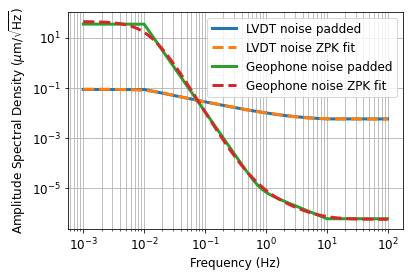

In [7]:
# Inspect the fit
plt.figure(figsize=(6, 4))
plt.loglog(f, n_lvdt_pad, lw=3, label="LVDT noise padded")
plt.loglog(f, abs(lvdt_fit.model(f, lvdt_fit.optimized_args)), "--", lw=3, label="LVDT noise ZPK fit")
plt.loglog(f, n_geophone_pad, lw=3, label="Geophone noise padded")
plt.loglog(f, abs(geophone_fit.model(f, geophone_fit.optimized_args)), "--", lw=3, label="Geophone noise ZPK fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel(r"Amplitude Spectral Density ($\mu \rm{m}/\sqrt{\rm{Hz}}$)")
plt.xlabel("Frequency (Hz)")
plt.show()

In [8]:
# Extract the numerator and denominators as inital guess for a transfer function fit.
lvdt_num = lvdt_fit.model.tf.minreal().num[0][0]
lvdt_den = lvdt_fit.model.tf.minreal().den[0][0]
geophone_num = geophone_fit.model.tf.minreal().num[0][0]
geophone_den = geophone_fit.model.tf.minreal().den[0][0]

lvdt_x0 = np.append(lvdt_num, lvdt_den)
geophone_x0 = np.append(geophone_num, geophone_den)

In [9]:
lvdt_model = kontrol.curvefit.model.TransferFunctionModel(
    nzero=lvdt_order, npole=lvdt_order, log_args=log_args)
lvdt_fit.optimizer = scipy.optimize.minimize

lvdt_fit.optimizer_kwargs = {
    "method": "Nelder-Mead",
    "x0": lvdt_x0 if not log_args else np.log10(lvdt_x0),
    "options": {
        "maxiter": len(lvdt_x0)*1000,
        "adaptive": True,
    }
}

lvdt_fit.model = lvdt_model
res_lvdt = lvdt_fit.fit()

In [10]:
geophone_model = kontrol.curvefit.model.TransferFunctionModel(
    nzero=geophone_order, npole=geophone_order, log_args=log_args)
geophone_fit.optimizer = scipy.optimize.minimize

geophone_fit.optimizer_kwargs = {
    "method": "Nelder-Mead",
    "x0": geophone_x0 if not log_args else np.log10(geophone_x0),
    "options": {
        "maxiter": len(geophone_x0)*1000,
        "adaptive": True,
    }
}

geophone_fit.model = geophone_model
res_geophone = geophone_fit.fit()

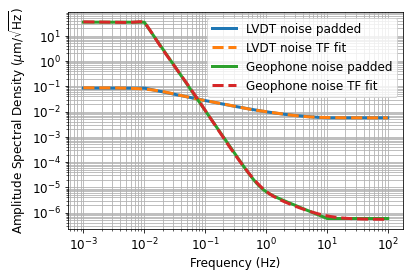

In [11]:
# Inspect the fit
plt.figure(figsize=(6, 4))
plt.loglog(f, n_lvdt_pad, lw=3, label="LVDT noise padded")
plt.loglog(f, abs(lvdt_fit.model(f, lvdt_fit.optimized_args)), "--", lw=3, label="LVDT noise TF fit")
plt.loglog(f, n_geophone_pad, lw=3, label="Geophone noise padded")
plt.loglog(f, abs(geophone_fit.model(f, geophone_fit.optimized_args)), "--", lw=3, label="Geophone noise TF fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel(r"Amplitude Spectral Density ($\mu \rm{m}/\sqrt{\rm{Hz}}$)")
plt.xlabel("Frequency (Hz)")
plt.show()

In [12]:
# Get the fitted transfer functions and "stablize" the poles and zeros.
lvdt_fit.model.args = lvdt_fit.optimized_args
lvdt_tf = lvdt_fit.model.tf
geophone_fit.model.args = geophone_fit.optimized_args
geophone_tf = geophone_fit.model.tf

lvdt_tf = kontrol.TransferFunction(lvdt_tf)
geophone_tf = kontrol.TransferFunction(geophone_tf)

# Negate unstable zeors and poles
lvdt_tf.stabilize()
geophone_tf.stabilize()

# Export
lvdt_tf.save("noise_lvdt.pkl")
geophone_tf.save("noise_geophone.pkl")